[*********************100%***********************]  4 of 4 completed



================= MONTE CARLO SIMULATION OF THE PORTFOLIO =================

------------------------------
Outlook: 10 years
Number of Simulations: 30000
------------------------------

 Portfolio Composition:

 Ticker Percentage
    VOO     35.00%
   QQQM     35.00%
   AVUV     15.00%
IUSN.DE     15.00%

------ HISTORICAL DATA ------
Avg Daily Return: 0.000664
Daily Volatility: 0.011657
-----------------------------

----- SIMULATION RESULTS (10 YEARS) -----
Initial Investment: $100.00
Mean Final Value:   $534.41
Median Final Value: $448.98
Worst Case (5%):    $169.08
Best Case (95%):    $1,188.40
-----------------------------------------


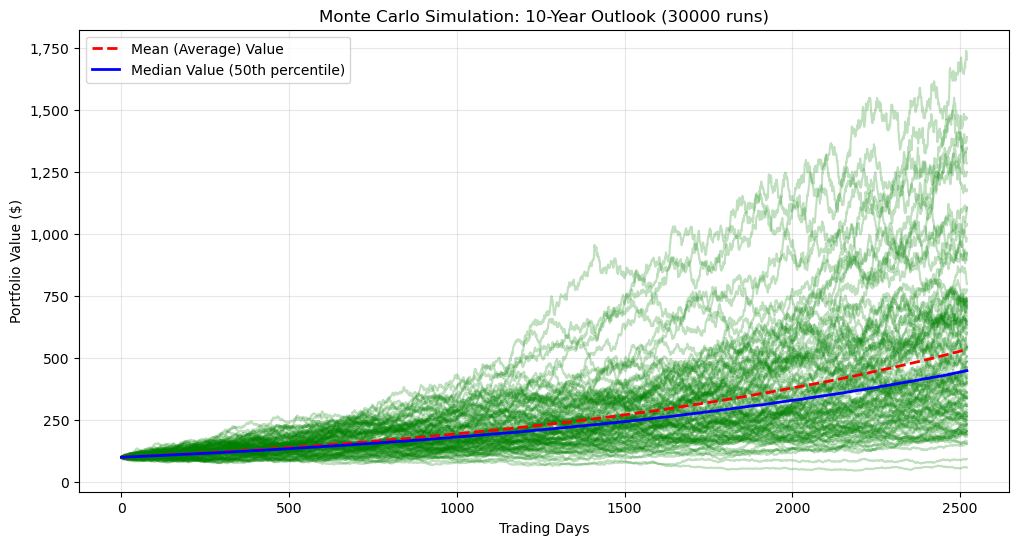

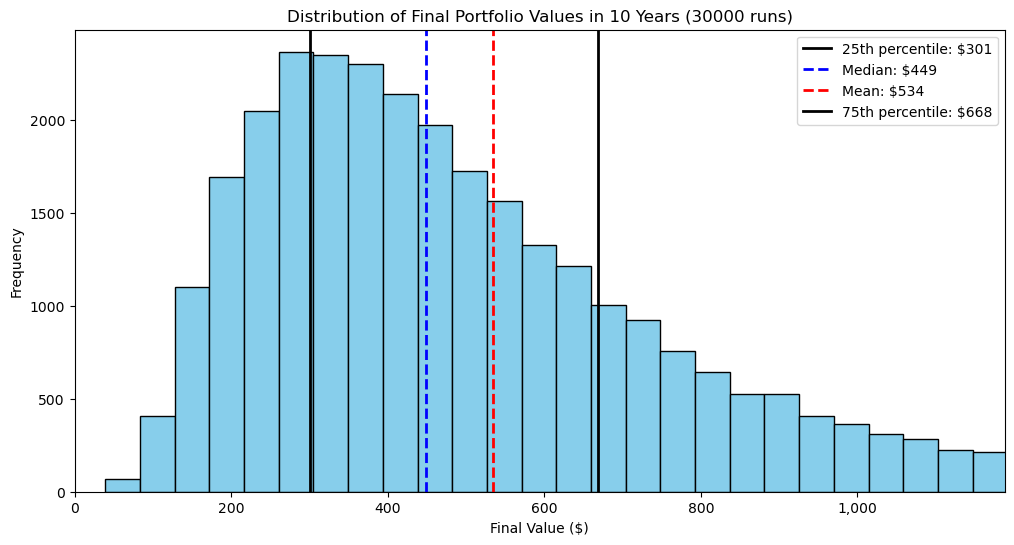

In [10]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

                        ## Import the data

# Download multiple tickers
tickers = ["VOO", "QQQM", "AVUV", "IUSN.DE"]

comp = [0.35, 0.35, 0.15, 0.15]

initial = 100

# Ensure weights sum to exactly 1.0
weights = np.array(comp)
weights /= weights.sum()

# Select start and end dates 
start_date = pd.to_datetime('today') - pd.DateOffset(years = 10)
end_date = pd.to_datetime('today')

# If any stock is traded on a non-US exchange, specify the ticker and the currency pair in a format as follows: 'RHM.DE': 'EURUSD=X'. 
# However, all the other currencies have to be converted to USD.
fx_pair = {'IUSN.DE': 'EURUSD=X'}

# Import the main piece of data, stock prices
data = yf.download(
    tickers,
    start = start_date,
    end = end_date,
    interval="1d",
    group_by='ticker',
    auto_adjust=True,
    threads = True
)

# Download FX Data
fx_needed = list({fx for fx in fx_pair.values() if fx.endswith("USD=X")})

# Don't slice ["Close"] immediately to ensure that structure is handled correctly
fx_data_raw = yf.download(
    fx_needed,
    start = start_date,
    end = end_date,
    auto_adjust = True,
    progress = False
)

# Handle cases where yfinance returns a Series (1 ticker) vs DataFrame (>1 ticker)
if len(fx_needed) == 1:
    # If it's a DataFrame with columns Open, Close, etc, extract Close
    if isinstance(fx_data_raw, pd.DataFrame):
        fx_rates = fx_data_raw["Close"]
    else:
        fx_rates = fx_data_raw
else:
    # If multiple tickers, extract Close
    fx_rates = fx_data_raw["Close"]

# Create a new table
converted = data.copy()

for ticker in tickers:
    if ticker in fx_pair:
        pair_name = fx_pair[ticker]
        
        # Get the specific rate series
        if isinstance(fx_rates, pd.DataFrame):
            rate = fx_rates[pair_name]
        else:
            rate = fx_rates # It is already a series if only 1 pair downloaded
            
        # different stock markets have different holidays, so a certain misalignment is possible. This line is here to prevent it. 
        # If a cell in a DataFrame is Null, ffill fills with a values that coresponds to a previous day
        rate = rate.reindex(converted.index).ffill()

        # Identify columns to convert (Open, High, Low, Close, etc.)
        cols_to_convert = [c for c in ["Open", "High", "Low", "Close", "Adj Close"] 
                           if c in converted[ticker].columns]
        
        # Apply conversion using to ensure the original dataframe is updated
        for col in cols_to_convert:
            converted.loc[:, (ticker, col)] = converted.loc[:, (ticker, col)].mul(rate)

# Extract Final "Close" Data
# Get only "Close" columns
final_close_prices = converted.xs('Close', axis=1, level=1)

                        ## Calculate key statistical parameters for the simulaton

# Calculate Daily Log Returns. Logarithmic return is better for long term simulations
log_returns = np.log(final_close_prices / final_close_prices.shift(1)).dropna()

# Calculate Portfolio Daily Return (Mean)
avg_daily_return = np.sum(log_returns.mean() * weights)

# Calculate Portfolio Volatility (Standard Deviation)
cov_matrix = log_returns.cov()
portfolio_std_dev = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))

# Simulation Parameters
years = 10
trading_days = 252
total_days = trading_days * years 
simulations = 30000

                        ## Monte Carlo Simulation

# Generate Random Z-Scores
Z = np.random.normal(0, 1, (total_days, simulations))

# Geometric Brownian Motion Formula:
# Calculate the daily drift
daily_drift = avg_daily_return - (0.5 * portfolio_std_dev ** 2)

# Calculate daily returns for all simulations
# (drift + shock(Z))
daily_sim_returns = daily_drift + (portfolio_std_dev * Z)

# Accumulate returns
cumulative_returns = np.cumsum(daily_sim_returns, axis=0)

# Apply to Initial Portfolio Value
# We add [0] row at the top to represent the starting day (Day 0 = Initial Value)
portfolio_simulations = initial * np.exp(cumulative_returns)
portfolio_simulations = np.vstack([np.full((1, simulations), initial), portfolio_simulations])

                        ## Final result and viz

# Get the results from the last day of the simulation
final_values = portfolio_simulations[-1, :]

# Calculate Key Statistics
expected_value = np.mean(final_values)
median_value = np.median(final_values)
# The worst case, bottom 5% 
worst_case = np.percentile(final_values, 5)   
# The best case, top 5%
best_case = np.percentile(final_values, 95)

df_initial_portfolio = pd.DataFrame({'Ticker': tickers,
                             'Percentage': comp
})

df_initial_portfolio = df_initial_portfolio.sort_values('Percentage', ascending = False)
df_initial_portfolio['Percentage'] = df_initial_portfolio['Percentage'] * 100
df_initial_portfolio['Percentage'] = df_initial_portfolio['Percentage'].map('{:.2f}%'.format)

print("\n================= MONTE CARLO SIMULATION OF THE PORTFOLIO =================\n")
print("------------------------------")
if years == 1:
    print(f"Outlook: {years} year")
else: 
    print(f"Outlook: {years} years") 
print(f"Number of Simulations: {simulations}")
print("------------------------------")
print("\n Portfolio Composition:\n")
print(df_initial_portfolio.to_string(index=False))

print(f"\n------ HISTORICAL DATA ------")
print(f"Avg Daily Return: {avg_daily_return:.6f}")
print(f"Daily Volatility: {portfolio_std_dev:.6f}")
print(f"-----------------------------")

if years == 1:
    print(f"\n----- SIMULATION RESULTS ({years} YEAR) -----")
else:
    print(f"\n----- SIMULATION RESULTS ({years} YEARS) -----")
print(f"Initial Investment: ${initial:,.2f}")
print(f"Mean Final Value:   ${expected_value:,.2f}")
print(f"Median Final Value: ${median_value:,.2f}")
print(f"Worst Case (5%):    ${worst_case:,.2f}")
print(f"Best Case (95%):    ${best_case:,.2f}")
print("-----------------------------------------")

plt.figure(figsize=(12, 6))

# Plot only the first 100 simulations to keep the chart readable
plt.plot(portfolio_simulations[:, :100], color='green', alpha=0.25)

# Plot Mean and Median values
plt.plot(np.mean(portfolio_simulations, axis=1), 'r--', linewidth=2, label='Mean (Average) Value')
plt.plot(np.median(portfolio_simulations, axis=1), 'b-', linewidth=2, label='Median Value (50th percentile)')
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.title(f'Monte Carlo Simulation: {years}-Year Outlook ({simulations} runs)')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Histogram of final results
plt.figure(figsize=(12, 6))
plt.xlim(left = 0, right = np.percentile(final_values, 95))
plt.hist(final_values, bins=100, color='skyblue', edgecolor='black')
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.axvline(np.percentile(final_values, 25), color='black', linestyle='solid', linewidth=2, label=f'25th percentile: ${np.percentile(final_values, 25):,.0f}')
plt.axvline(median_value, color='b', linestyle='dashed', linewidth=2, label=f'Median: ${median_value:,.0f}')
plt.axvline(expected_value, color='r', linestyle='dashed', linewidth=2, label=f'Mean: ${expected_value:,.0f}')
plt.axvline(np.percentile(final_values, 75), color='black', linestyle='solid', linewidth=2, label=f'75th percentile: ${np.percentile(final_values, 75):,.0f}')
if years == 1:
        plt.title(f'Distribution of Final Portfolio Values in {years} Year ({simulations} runs)')
else: 
        plt.title(f'Distribution of Final Portfolio Values in {years} Years ({simulations} runs)')
plt.xlabel('Final Value ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
